# Project Notebook

This project notebook replicates the work presented in the final report (ADD LINK).

#### Imports

In [1]:
# Basics
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical libraries
from scipy.stats import norm, shapiro, kstest, chi2_contingency

# Kaplan-Meier Estimator
from lifelines import KaplanMeierFitter, WeibullFitter

# Custom utils functions
import sys; sys.path.append("./libraries/")
from utils import *

#### Settings

In [2]:
# Relative Paths
RAW_DATA = "../data/raw/"
PROC_DATA = "../data/processed/"

# Flags
process = False

# Replace files
write_2_disk = False

# Seed for reproducibility
seed = 28

# Data

## Load and match datasets
We have two different dataset sources with different identifiers. To match players from Transfermarkt with their attributes from soFIFA, we use a custom function that looks at their names, date of birth and nationality to ensure they are the same player.

In [3]:
# If process, load raw data and apply matching between datasets
# NOTE: It may take several minutes
if process:
    # Raw player's datasets
    transfermarkt = pd.read_csv('https://query.data.world/s/gksm6hx4xzgjaed7tia2uzpafwvyjo?dws=00000')
    fifa22 = pd.read_csv(RAW_DATA + "FIFA22_player_ratings.csv") # FIFA player attributes from 2022
    fifas21 = pd.read_csv(RAW_DATA + "FIFA21_player_ratings.csv") # FIFA player attributes from 2022
    # This appends players from 2021 not present in 2022
    extended = set(fifas21.sofifa_id).difference(set(fifa22.sofifa_id))
    FIFA = pd.concat([fifa22, fifas21[fifas21.sofifa_id.isin(extended)]]).reset_index()

    # Remove uninformative columns
    transfermarkt.drop(["player_code", "agent_name", "image_url", "url"], axis=1, inplace=True)
    FIFA.drop(["player_url", "club_team_id", "club_position", "club_jersey_number", "club_loaned_from", "club_joined", 
                "nationality_id", "nation_team_id", "nation_jersey_number", "real_face", "player_tags", "player_face_url", 
                "club_logo_url", "club_flag_url", "nation_logo_url", "nation_flag_url"], axis=1, inplace=True)
    
    # Find matches using custom function
    longname_matches = match_players(transfermarkt, FIFA)
    # Append the extracted FIFA long names
    transfermarkt["FIFA_long_name"] = longname_matches

    ## Merge players with FIFA attributes
    # Create a unique identifier with long name and year of birth
    transfermarkt["fifa_id"] = transfermarkt["FIFA_long_name"] + "-" + pd.to_datetime(transfermarkt["date_of_birth"]).dt.year.astype(str)
    FIFA["fifa_id"] = FIFA.long_name + "-" + pd.to_datetime(FIFA["dob"]).dt.year.astype(str)
    # Join
    players = transfermarkt.merge(FIFA, on="fifa_id", how="inner")
    # Drop temp id cols
    players.drop(["name", "fifa_id", "sofifa_id"], axis=1, inplace=True)
    # Save dataset
    players.to_csv(PROC_DATA + "players_wFIFAattributes.csv", index=False)

# Else load processed data
else:
    players = pd.read_csv(PROC_DATA + "players_wFIFAattributes.csv")

# Get valuation data
valuations = pd.read_csv('https://query.data.world/s/y4qg2twfvou4w2ghz6o3evju32g7yn?dws=00000') 
# ... (we can get some more datasets if needed)

# Glance at data
print(players.info())
players.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11159 entries, 0 to 11158
Columns: 112 entries, player_id to gk
dtypes: float64(15), int64(44), object(53)
memory usage: 9.5+ MB
None


,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
0,3875,Jermain,Defoe,Jermain Colin Defoe,2021,England,London,England,1982-10-07,Centre-Forward,...,43+2,43+2,43+2,43+2,40+2,38+2,38+2,38+2,40+2,18+2
1,4742,Christophe,Lepoint,Christophe Lepoint,2022,Belgium,Brussel,Belgium,1984-10-24,Central Midfield,...,68-1,68-1,68-1,62+2,62+2,67,67,67,62+2,16+2
2,6838,Henok,Goitom,Henok Goitom,2015,Sweden,Solna,Eritrea,1984-09-22,Centre-Forward,...,55+2,55+2,55+2,50+2,48+2,50+2,50+2,50+2,48+2,17+2
3,10003,Wes,Morgan,Wes Morgan,2020,England,Nottingham,Jamaica,1984-01-21,Centre-Back,...,64+2,64+2,64+2,54+2,57+2,73,73,73,57+2,16+2
4,10471,NaN,Luiz Gustavo,Luiz Gustavo Dias,2021,Brazil,Pindamonhangaba,Brazil,1987-07-23,Defensive Midfield,...,75+2,75+2,75+2,71+3,71+3,75+2,75+2,75+2,71+3,17+3


# EDA
TODO

We can also plot the histogram of all players' age in the Transfermarkt dataset, to get a sense of the age distribution across players.

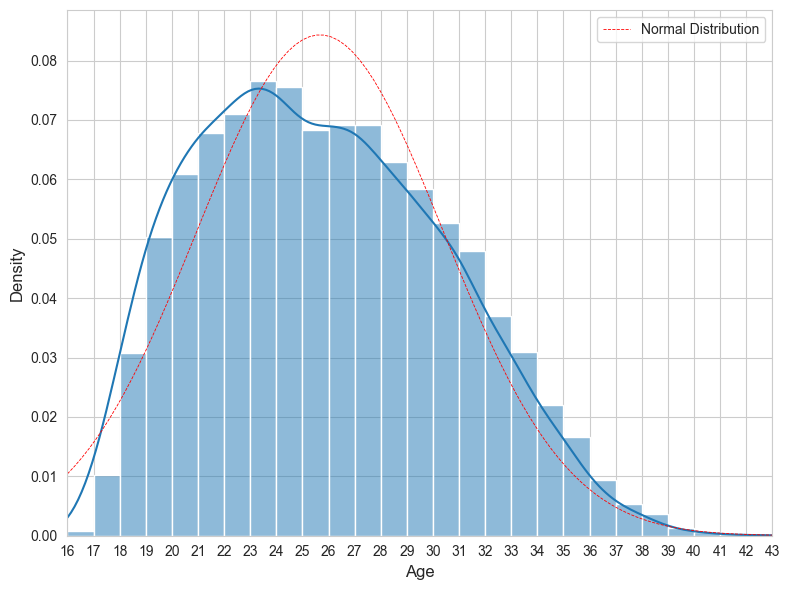

In [4]:
# Set the style
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8,6))

# Plot the histogram of ages
sns.histplot(data=players, x="age", kde=True, stat="density", bins=np.arange(players.age.min(), players.age.max() + 1), ax=ax)

# Fit a normal distribution to the data
mu, std = np.mean(players.age), np.std(players.age)
xmin, xmax = plt.xlim(players.age.min(), players.age.max())
plt.xticks(players.age.unique())
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, '--r', linewidth=0.6, label='Normal Distribution')

# Add labels and title
#plt.title('Histogram with Normal Distribution Fit')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

The data appears roughly normally distributed, with a slight right tail. To test for a normal distribution fit, we use a Chi-square goodness of fit test, with an alpha level of 0.05. The chi-square test (Snedecor and Cochran, 1989) is used to test if a sample of data came from a population with a specific distribution. <br>
$H_0$:	The data follow a specified distribution (i.e., Normal). <br>
$H_a$:	The data do not follow the specified distribution.


In [5]:
# Select an alpha level
alpha = 0.05

# Total observations
N = players.shape[0]

# Parameters for the normal distribution (mean and standard deviation)
mean_age = np.mean(players.age)
std_age = np.std(players.age)

# Range of ages
ages = pd.Series(np.arange(players.age.min(), players.age.max()+1))

# Calculate the probability function for each age
expected_frequencies = N * norm.pdf(ages, loc=players.age.mean(), scale=players.age.std())

# Get the observed frequencies
observed_frequencies = players.groupby("age").size()

# Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency([observed_frequencies, expected_frequencies])

print(f"Chi-squared Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

if p_value < alpha:
    print("We reject the null hypothesis, and thus conclude the distribution is not normal.")
else:
    print("We cannot reject the null hypothesis, and thus it can be possible that the distribution is normal.")

Chi-squared Statistic: 330.2726147151785
P-value: 6.398325123547772e-54
Degrees of Freedom: 27
We reject the null hypothesis, and thus conclude the distribution is not normal.


# Survival Analysis
The first step is to recognize retired players. We apply the assumption that a player is retired if he hasn't played for over a year, has no current club, no market value and no contract.

In [6]:
# Detect retired:
## Conditions:
### Last season < 2021
### No current club (NAN)
### No Market value in EUR (NAN)
### No Contract Expiration date (NAN)

# Use custom function generate boolean flag for "Retired" players
players = detect_retired(players)

# A glance to the retire players
players[players.retired].head()

,player_id,first_name,last_name,FIFA_long_name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,retired
13,26105,Valter,Birsa,Valter Birsa,2019,Jugoslawien (SFR),Sempeter pri Gorici,Slovenia,1986-08-07,Attacking Midfield,...,64+2,64+2,63+2,60+2,59+2,59+2,59+2,60+2,11+2,True
32,42086,Timo,Perthel,Timo Perthel,2013,Germany,Kaiserslautern,Germany,1989-02-11,Left-Back,...,64+2,64+2,65+1,64+2,64+2,64+2,64+2,64+2,15+2,True
57,56820,Jérémy,Sorbon,Jérémy Sorbon,2018,France,Caen,France,1983-08-05,Centre-Back,...,64+2,64+2,59+2,60+2,69,69,69,60+2,17+2,True
73,62240,Maynor,Figueroa,Maynor Alexis Figueroa Róchez,2014,Honduras,Jutiapa,Honduras,1983-05-02,Left-Back,...,66+2,66+2,63+2,63+2,68,68,68,63+2,17+2,True
119,101922,Fabio,Pisacane,Fabio Pisacane,2020,Italy,Napoli,Italy,1986-01-28,Centre-Back,...,65+2,65+2,66+2,67+2,70,70,70,67+2,19+2,True


Now are all players in the dataset contain a "retired" flag.

## FOOTBALL PLAYERS PROFESSIONAL LIFE TABLE
Similar to the life tables in traditional Survival Analysis, the "professional life" table will compute the probability of retiring ('h') at a given age (based on their frequency), and a "Activity" ('A') probability at a given age, computed as the probability of NOT being retired at that age.

In [7]:
retire_table = get_retire_table(players, ci=(0.025, 0.975), bootstrap_settings={"simulations": 10000}, random_seed=seed)

KeyError: "['S'] not in index"

In [ ]:
# Reverse the order of the column
retire_table['Reversed_S'] = retire_table['S'][::-1]

# Calculate cumulative sum in reverse order
retire_table['Cumulative_Sum_Reverse'] = retire_table['Reversed_S'].cumsum()

# Reverse the cumulative sum column back to the original order
retire_table['Cumulative_Sum'] = retire_table['Cumulative_Sum_Reverse'][::-1]

# Drop intermediate columns if needed
df = retire_table.drop(['Reversed_S', 'Cumulative_Sum_Reverse'], axis=1)

In [ ]:

df

In [ ]:
retire_table

Let's plot the survival curve with the confidence intervals.

In [ ]:
dtypes= {k: int for k in retire_table.columns[:3]}
dtypes.update({k: float for k in retire_table.columns[3:]})
write_latex_table(retire_table, dtypes=dtypes)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 6))

# Plot Survival curve
sns.lineplot(data=retire_table, x="age", y="S", drawstyle="steps", linewidth=2, ax=ax)
# Plot Conf. Intervals
ax.fill_between(retire_table.age, retire_table[0.025], retire_table[0.975], alpha=0.2, step="pre", label="Confidence Interval")
ax.set_xlim(retire_table.age.min())
ax.set_xticks(retire_table.age)
ax.set_xlabel("Age", weight="bold") 
ax.set_ylabel("Activity Rate (Â)", weight="bold")
sns.despine(ax=ax, top=True, right=True)
;

In [ ]:
# Create a Kaplan-Meier estimator
kmf = KaplanMeierFitter(alpha=0.05)

# Fit the data to the estimator
kmf.fit(durations=players['age'], event_observed=players['retired'])

# Plot the Kaplan-Meier curve
ax = kmf.plot_survival_function()
# Look at the KM curves
error = sns.utils.ci_to_errsize((retire_table[0.025], retire_table[0.975]), retire_table.S)
sns.lineplot(data= retire_table, x="age", y= "S", drawstyle="steps", color="red", linestyle="--", alpha=0.5, ax=ax, errorbar=None)
ax.errorbar(retire_table.age, retire_table.S, error, color='red', fmt='none', linestyle="-", alpha=0.3)

plt.title('Kaplan-Meier Survival Curve')
plt.legend(["KM Estimate", "KM 95% Conf. Interv.", "Sample Survival","Sample Survival 95% Conf. Interv."])
plt.xlabel('Age')
plt.ylabel('Survival Probability')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


Let's see if there are differences between two groups of physics

In [ ]:
players_low, players_high = players[players.work_rate.isin(["Low/Low", "Low/Medium", "Medium/Low"])], players[players.work_rate.isin(["High/High", "High/Medium", "Medium/High"])]

retire_table_low, retire_table_high = get_retire_table(players_low, random_seed=seed), get_retire_table(players_high, random_seed=seed)

In [ ]:
# We group the physics into three groups: lean, normal and stocky
body_types = ["Lean", "Normal", "Stocky"]

ecdfs = []

fig, ax = plt.subplots(figsize=(14,6))

legend = []

for bt in body_types:

    df = players[players.body_type.str.contains(bt)]

    # Create a Kaplan-Meier estimator
    kmf = KaplanMeierFitter(alpha=0.05)

    # Fit the data to the estimator
    kmf.fit(durations=df['age'], event_observed=df['retired'], timeline=range(players["age"].min(), players["age"].max()))
    kmf.plot_survival_function()
    # Plot the Kaplan-Meier curve
    #ecdfs.append(kmf.ecdf())

    legend.append(bt)
    legend.append("95% CI")

plt.title('Kaplan-Meier Survival Curve')
plt.legend(legend)
plt.xlabel('Age')
plt.ylabel('Survival Probability')
sns.despine()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(14,6))

legend = ["Low", "High"]


sns.lineplot(data= retire_table_low, x="age", y= "S", drawstyle="steps", color="red", alpha=0.5, ax=ax, err_style="bars", errorbar="ci")
sns.lineplot(data= retire_table_high, x="age", y= "S", drawstyle="steps", color="green", alpha=0.5, ax=ax,  err_style="bars")
ax.errorbar(x, y_mean, error, color='tab:blue', ecolor='tab:blue')

plt.title('Kaplan-Meier Survival Curve')
plt.legend(legend)
plt.xlabel('Age')
plt.ylabel('Survival Probability')
sns.despine()
plt.show()